In [1]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

--2025-02-28 09:38:22--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  25.2MB/s    in 20s     

2025-02-28 09:38:43 (21.8 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



['--2025-02-28 09:38:43--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
 'Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152',
 'Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 451020800 (430M) [application/x-tar]',
 'Saving to: ‘VOCtest_06-Nov-2007.tar’',
 '',
 '',
 'VOCtest_06-Nov-2007   0%[                    ]       0  --.-KB/s               ',
 'VOCtest_06-Nov-2007   0%[                    ]  81.24K   278KB/s               ',
 'VOCtest_06-Nov-2007   0%[                    ] 550.70K   941KB/s               ',
 'VOCtest_06-Nov-2007   0%[                    ]   3.00M  3.42MB/s               ',
 'VOCtest_06-Nov-2007   1%[                    ]   8.28M  7.08MB/s               ',
 'VOCtest_06-Nov-2007   3%[                    ]  13.51M  9.87MB/s               ',
 'VOCtest_06-Nov-2007   3%[                    ]  17.15M  10.4MB/s          

In [2]:
!tar xvf VOCtrainval_06-Nov-2007.tar
#!tar xvf VOCtest_06-Nov-2007.tar

!rm VOCtrainval_06-Nov-2007.tar
#!rm VOCtest_06-Nov-2007.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/001732.jpg
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC2007/JPEGImages/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  xml.etree.ElementTree as ET
import cv2
import shutil
import torch
import os
from torch.utils.data import TensorDataset, DataLoader

In [4]:
train_images="/content/VOCdevkit/VOC2007/JPEGImages/"
train_maps="/content/VOCdevkit/VOC2007/Annotations/"

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

N_CLASSES=len(classes)
H,W=224,224
SPLIT_SIZE=int(H/32)
BATCH_SIZE=32

In [ ]:
#### WRITE FUNCTION TO EXTRACT BOUNDING BOXES FROM EACH IMAGE

In [5]:
# This function preprocesses an XML file containing object detection annotations.
def preprocess_xml(filename):

    # Parse the XML file using ElementTree.
    tree = ET.parse(filename)
    root = tree.getroot()

    # Extract image size from the XML.
    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
    width = float(size_tree.find('width').text)

    # Initialize list to store bounding boxes.
    bounding_boxes = []

    # Create a dictionary to map class names to indices.
    class_dict = {classes[i]: i for i in range(len(classes))}

    # Iterate through each object annotation in the XML.
    for object_tree in root.findall('object'):
        # Extract bounding box coordinates.
        for bounding_box in object_tree.iter('bndbox'):
            xmin = float(bounding_box.find('xmin').text)
            xmax = float(bounding_box.find('xmax').text)
            ymin = float(bounding_box.find('ymin').text)
            ymax = float(bounding_box.find('ymax').text)
            break

        # Extract class name of the object.
        class_name = object_tree.find('name').text

        # Calculate normalized bounding box coordinates and append to the list.
        bounding_box = [
            (xmin + xmax) / (2 * width),
            (ymin + ymax) / (2 * height),
            (xmax - xmin) / width,
            (ymax - ymin) / height,
            class_dict[class_name]
        ]
        bounding_boxes.append(bounding_box)

    # Convert the list of bounding boxes to a TensorFlow tensor and return.
    return torch.tensor(bounding_boxes)

In [6]:
### INITIALISING THE YOLO OUTPUT FUNCTION
## Initialize output label tensor: This creates a 3D numpy array of zeros with dimensions SPLIT_SIZE x SPLIT_SIZE x (N_CLASSES + 5). SPLIT_SIZE is the number of grid cells the image is divided into along the width and height, and N_CLASSES is the number of object classes. The + 5 accounts for the 5 parameters of the bounding box (objectness score, x, y, width, height).
## Calculate grid positions: For each bounding box, it calculates the grid cell coordinates (grid_x, grid_y) that the center of the bounding box falls into. This is done by multiplying the normalized x and y coordinates of the bounding box center by SPLIT_SIZE.##
## Convert to integer grid indices: The floating point grid coordinates are converted to integer indices (i, j) which represent the row and column of the grid cell in the output tensor.

[![22.png](https://i.postimg.cc/4Nhq6cv8/22.png)](https://postimg.cc/jLtMKLFN)

[![23.png](https://i.postimg.cc/T1ZRkXHB/23.png)](https://postimg.cc/FkV5Rwvx)

In [7]:
def generate_output(bounding_boxes):
    # Initialize output label tensor
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    # Iterate through bounding boxes
    for b in range(len(bounding_boxes)):
        # Calculate grid positions
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE

        # Convert to integer grid indices
        i = int(grid_x)
        j = int(grid_y)

        # Assign values to output label tensor
        output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
        output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.

    # Convert output label tensor to TensorFlow tensor
    return torch.tensor(output_label)

In [8]:
im_paths=[]
xml_paths=[]

for i in os.listdir(train_maps)[:5000]:
    im_paths.append(train_images+i[:-3]+'jpg')
    xml_paths.append(train_maps+i)

In [9]:
import torchvision.transforms as transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
])

images = []
for im_path in im_paths:
    # Open image using PIL
    img = Image.open(im_path).convert('RGB')

    # Apply transformations
    img_tensor = transform(img)

    images.append(img_tensor)

# Stack tensors
images = torch.stack(images)

In [10]:
boxes = []

for xml_path in xml_paths:

    boxes.append(generate_output(preprocess_xml(xml_path)))

boxes_tensor = torch.stack(boxes, dim=0)

In [11]:
type(boxes_tensor)

torch.Tensor

In [12]:
import torch.nn as nn
import torchvision.models as models

NUM_FILTERS = 512
OUTPUT_DIM = int(N_CLASSES + 5)

# Load pre-trained ResNet50
base_model = models.resnet50(pretrained=True)

# Remove the last fully connected layer
base_model = nn.Sequential(*list(base_model.children())[:-2])

# Freeze the base model
for param in base_model.parameters():
    param.requires_grad = False


# Define additional layers
conv_layers = nn.Sequential(
    nn.Conv2d(2048, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),

    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),

    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1)
)

flatten = nn.Flatten()

dense_layers = nn.Sequential(
    nn.Linear(NUM_FILTERS * (H // 32) * (W // 32), NUM_FILTERS),
    nn.BatchNorm1d(NUM_FILTERS),
    nn.LeakyReLU(0.1),

    nn.Linear(NUM_FILTERS, int(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM)),
    nn.Sigmoid()
)

# Combine all layers into a single sequential model
model = nn.Sequential(
    base_model,
    conv_layers,
    flatten,
    dense_layers,
    nn.Unflatten(1, (SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))
)

# Print model summary
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

[![24.png](https://i.postimg.cc/zGRVnx3y/24.png)](https://postimg.cc/w1gqzcXz)

In [13]:
def difference(x, y):
    return torch.sum((y - x)**2)

def yolo_loss(y_true, y_pred):
    target = y_true[..., 0]  # Grid cell where we have information of object presence

    #--------------------------------------- for object

    target_indices = target == 1
    y_pred_extract = y_pred[target_indices]
    y_target_extract = y_true[target_indices]

    object_loss = difference(y_pred_extract[..., 0].float(), torch.ones_like(y_pred_extract[..., 0]).float())

    #------------------------------------------------------ for no object

    target_indices_no_obj = target == 0
    y_pred_extract_no_obj = y_pred[target_indices_no_obj]
    y_target_extract_no_obj = y_true[target_indices_no_obj]

    no_obj_loss = difference(y_pred_extract_no_obj[..., 0].float(), torch.zeros_like(y_pred_extract_no_obj[..., 0]).float())

    #-------------------------------------------------------- for object class loss

    y_pred_extract_class = y_pred[target_indices][:, 5:]
    class_extract = y_true[target_indices][:, 5:]

    class_loss = difference(y_pred_extract_class.float(), class_extract.float())

    #--------------------------------------------------------- for object center loss

    y_pred_extract_center = y_pred[target_indices][:, 1:3]
    center_target = y_true[target_indices][:, 1:3]

    center_loss = difference(y_pred_extract_center.float(), center_target.float())

    #------------------------------------------------------- for width and height

    size_pred = y_pred[target_indices][:, 3:5]
    size_target = y_true[target_indices][:, 3:5]

    size_loss = difference(torch.sqrt(torch.abs(size_pred.float())), torch.sqrt(torch.abs(size_target.float())))

    box_loss = center_loss + size_loss

    lambda_coord = 5
    lambda_no_obj = 0.5

    loss = object_loss + (lambda_no_obj * no_obj_loss) + lambda_coord * box_loss + class_loss

    return loss

In [14]:
# Move model and data to MPS device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
boxes = torch.stack(boxes, dim=0)  # stacks the list into a tensor of shape (N, 7, 7, 25)
boxes = boxes.to(device)
images = images.to(device)



# Define your loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Assuming batch size of 32 and iterating through batches
    batch_size = 32
    for i in range(0, len(images), batch_size):
        img_batch = images[i:i+batch_size]
        target_batch = boxes[i:i+batch_size]

        # Forward pass
        outputs = model(img_batch)

        # Assuming you have a custom YOLO-like loss function
        loss = yolo_loss(target_batch,outputs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (len(images) / batch_size)}')

print('Finished Training')

Epoch [1/2], Loss: 257.34393266601563
Epoch [2/2], Loss: 202.56886677246095
Finished Training


In [ ]:
## Write code for  Single Shot MultiBox Detector

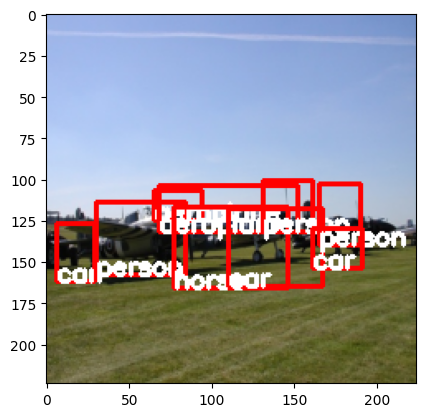

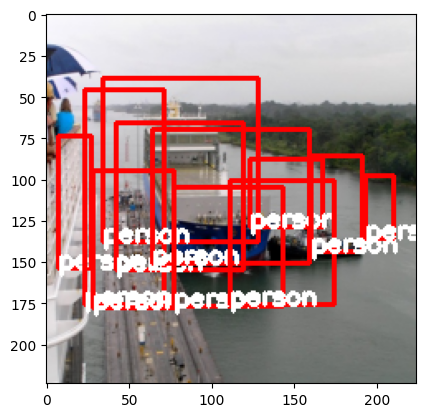

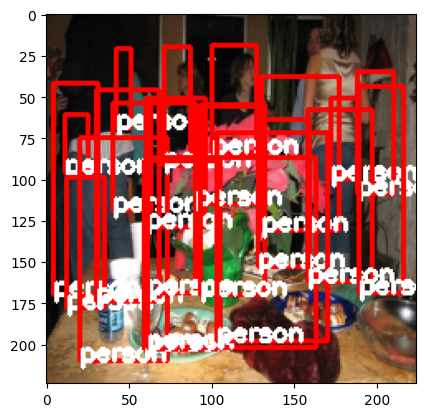

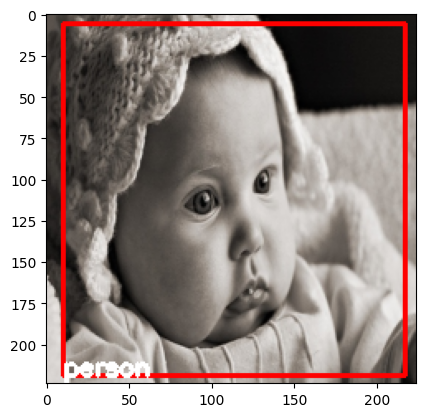

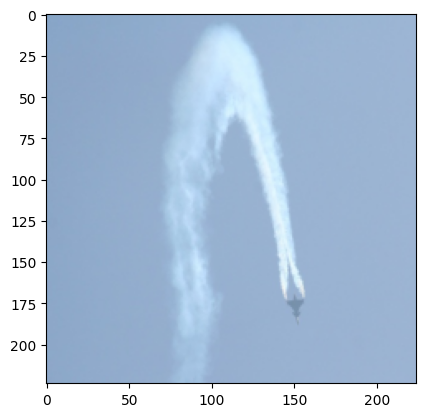

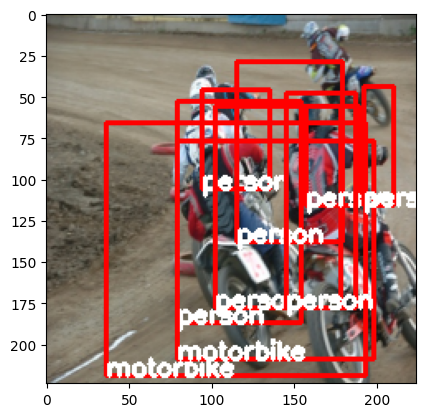

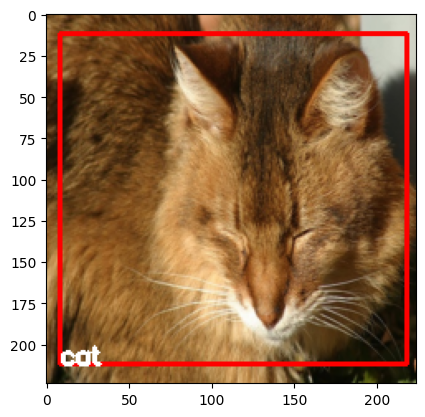

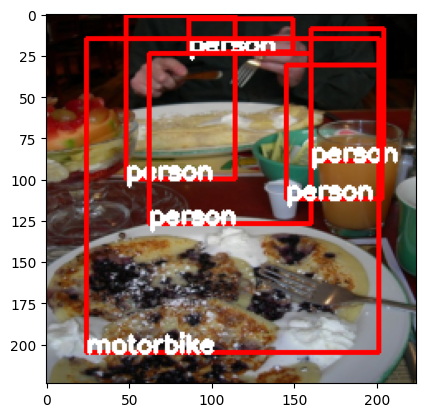

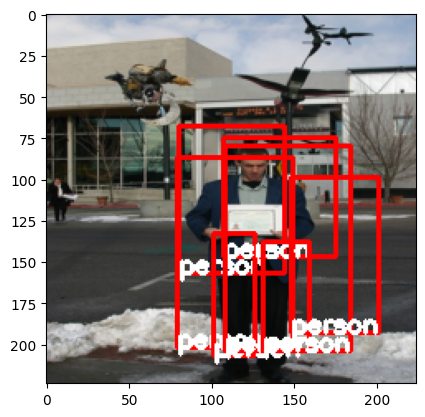

In [15]:
for j in [60,10,5,4,3416,500,600,800,560]:

    output = model(images[j:j+32])[:1] #SINCE MODEL TAKES 32 AS BATCH AND NOT SINGLE IMAGE

    # Threshold for detection
    THRESH = 0.25

    # Get object positions
    object_positions = torch.where(output[..., 0] >= THRESH)
    selected_output = output[object_positions]

    # Initialize lists for final boxes and scores
    final_boxes = []
    final_scores = []

    # Iterate through object positions
    for i in range(len(object_positions[0])):
        if selected_output[i][0] > THRESH:
            # Extract box parameters
            output_box = selected_output[i][1:5].float()
            x_centre = (object_positions[1][i] + output_box[0]) * 32
            y_centre = (object_positions[2][i] + output_box[1]) * 32
            x_width, y_height = torch.abs(224 * output_box[2]), torch.abs(224 * output_box[3])
            x_min, y_min = int(x_centre - (x_width / 2)), int(y_centre - (y_height / 2))
            x_max, y_max = int(x_centre + (x_width / 2)), int(y_centre + (y_height / 2))

            # Adjust bounding box coordinates
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(224, x_max)
            y_max = min(224, y_max)

            # Append to final boxes
            final_boxes.append([x_min, y_min, x_max, y_max,
                               classes[torch.argmax(selected_output[i][5:]).item()]])
            final_scores.append(selected_output[i][0].item())


    img = np.array(images[j].permute(1, 2, 0).to('cpu')).copy()

    for i in range(len(final_boxes)):

        # Extract object classes and boxes
        object_classes = final_boxes[i][4]
        nms_output = final_boxes[i][0:4]

        x1, y1 = nms_output[:2]
        x2, y2 = nms_output[2:]

        # Specify the color (in BGR format) and thickness
        color = (255, 0, 0)
        thickness = 2

        # Draw the rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

        # Add text (object classes)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        text_position = (x1, y2)

        cv2.putText(img, object_classes, text_position, font, font_scale, font_color, thickness)
    plt.imshow(img)
    plt.show()